In [7]:
import numpy as np
from scipy.linalg import svd, svdvals
from numpy.linalg import inv, eig, pinv
from numpy import dot, multiply, diag, power, pi, exp, sin, cos, cosh, tanh, real, imag
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr

from matplotlib import rc

font = {"family": "serif", "weight": "normal", "size": 13}
rc("font", **font)
rc("text", usetex=True)

# Proper Orthogonal Decomposition (POD)

Proper orthogonal decomposition reduces the order of a system by converting data into low-dimension modes.

### Data imported from GLORYS12V1

In [ ]:

dsr = xr.open_dataset("data\GLORYS\GPGP_flow_2023_06;09.nc", engine="netcdf4")

d = min(len(dsr["latitude"]), len(dsr["longitude"]))
resolution_angle = dsr["latitude"][1]-dsr["latitude"][0]  

Xc = np.linspace(min(dsr["longitude"]),int(min(dsr["longitude"])+d*resolution_angle),d)
Yc = np.linspace(max(dsr["latitude"]),max(dsr["latitude"])-int(d*resolution_angle),d)

### Computation of the Proper Orthogonal Decomposition :
Singular Value Decomposition of the absolute velocity field

In [21]:
USpd = np.nan_to_num(np.array(dsr["uo"][:,0,:d,:d]))
VSpd = np.nan_to_num(np.array(dsr["vo"][:,0,:d,:d]))

Spd = np.sqrt(USpd**2 + VSpd**2)

#vector snapshot transformation 
SpdS = np.transpose(Spd.reshape(Spd.shape[0],Spd.shape[1]*Spd.shape[2]))

# SVD of input matrix
U,Sig,Vh = svd(SpdS, False)

#correction coefficient on U (-1,1,-1,...)
coef = np.linspace(1,SpdS.shape[1],SpdS.shape[1])
coef = np.power(-1,coef)
U = U*coef



### Computation of the energy of each mode

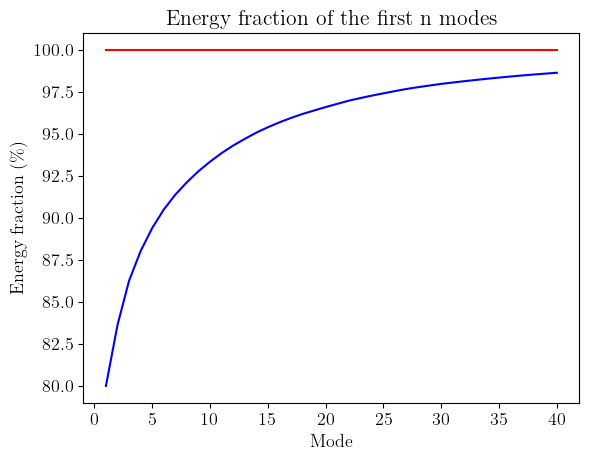

In [ ]:
#computing energy fraction
E_frac = Sig**2/np.sum(Sig**2)

#cumulative energy fraction
cummuE_frac = E_frac
for i in range(1,len(E_frac)) :
    cummuE_frac[i] += cummuE_frac[i-1]

plt.title("Energy fraction of the first n modes")
plt.xlabel("Mode")
plt.ylabel("Energy fraction (\%)")
plt.plot(np.linspace(1,40,40),cummuE_frac[:40]*100,color='blue')
plt.plot(np.linspace(1,40,40),np.ones(40)*100,color='red')

### Visualisation of the modes

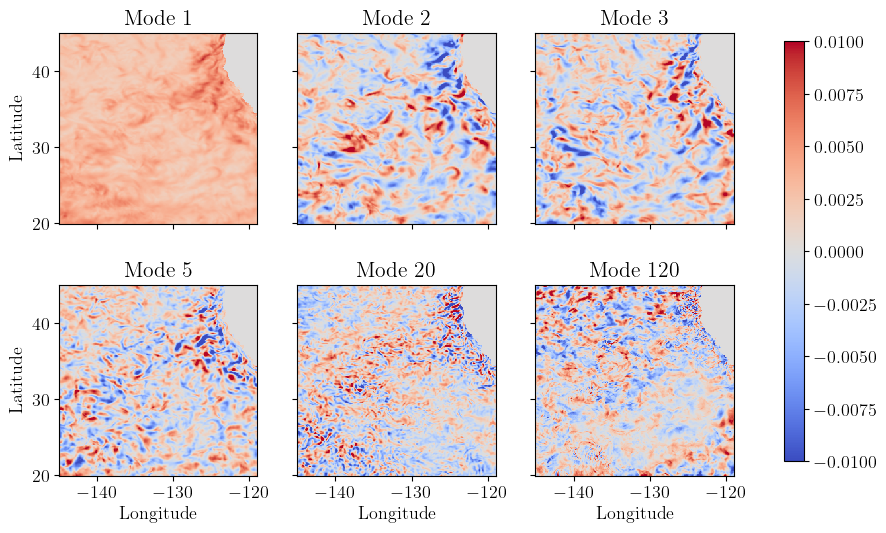

In [23]:
modes = [1,2,3,5,20,120]
fig, axs = plt.subplots(2,3,figsize = (10,6),sharex=True,sharey=True)

v =0.01
for i,ax in enumerate(axs.flatten()):
    ax.set_title("Mode "+str(modes[i]))
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
        
    im = ax.pcolormesh(Xc,Yc,np.flip(np.transpose(U)[modes[i]-1].reshape(USpd.shape[1],USpd.shape[2]),axis = 0), cmap = "coolwarm",vmax = v,vmin = -v)

    ax.set_aspect('equal')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

### Reconstruction of the original field with some of the modes 
The rank corresponds to the number of modes taken for the reconstruction

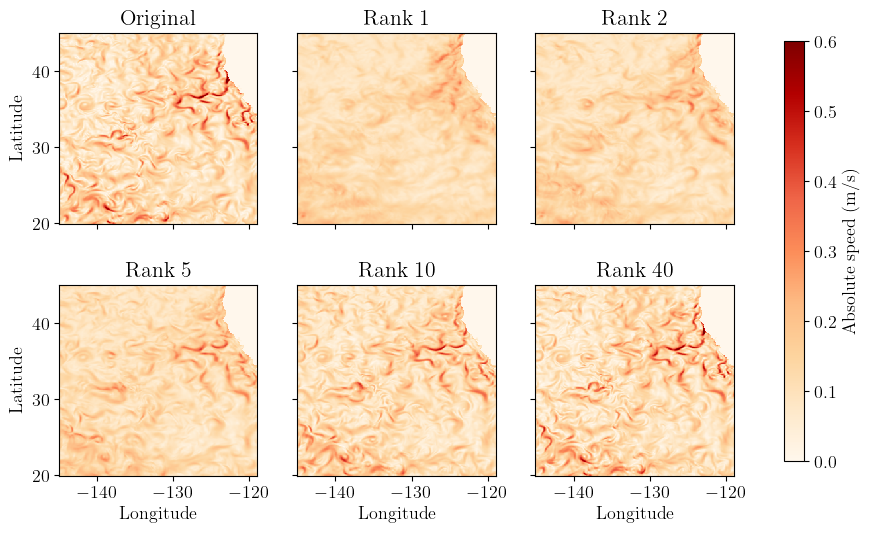

In [20]:
r = 5
r2 = 40
A = U.T @ SpdS

rank = [150,1,2,5,10,40]
fig, axs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True)

v =0.6
for i,ax in enumerate(axs.flatten()):
    ax.set_title("Rank "+str(rank[i]))
    if rank[i] == 150 :
        ax.set_title("Original")
    if i == 0 or i ==3 :
        ax.set_ylabel("Latitude")
    if i >= 3 :
        ax.set_xlabel("Longitude")
    ax.set_aspect('equal', adjustable='box')
    SpdSr = U[:,:rank[i]] @ A[:rank[i],:]
    im = ax.pcolormesh(Xc,Yc,np.flip(np.transpose(SpdSr)[0].reshape(USpd.shape[1],USpd.shape[2]),axis = 0), cmap = "OrRd",vmax = v,vmin = 0)

fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax,label='Absolute speed (m/s)')